In [1]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

/home/ollie/pscholz/tripyview_github


In [2]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path ='/work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/'

save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= 5
which_mode= 'hslice'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'temp'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, 1000

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
do_clim   = True
which_clim= 'phc3'
clim_path = '/work/ollie/pscholz/INIT_HYDRO/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = None
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 3 
do_rescale= None #'log10'
which_dpi = 300
proj      = 'pc'

In [3]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if which_cycl is not None: 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if ref_path is not None:
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
        
#______________________________________________________________________________________________________
cinfo=dict({'cstr':cstr, 'cnum':cnum})     
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac
if climit   is not None: cinfo['climit']=climit    
if chist    is not None: cinfo['chist' ]=chist
if ctresh   is not None: cinfo['ctresh']=ctresh
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record

 > found *.pckl file: /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node.pckl
 > comp. e_resol from mean
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
0 /home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/


In [4]:
#___LOAD FESOM2 REFERENCE DATA________________________________________________________________________
if ref_path is not None:
    print(ref_path)
    if depth =='bottom':
        data_ref = tpv.load_data_fesom2(mesh, ref_path, vname=vname, year=ref_year, mon=ref_mon, day=ref_day, record=ref_record, 
                                      depth=None, descript=ref_name, do_info=False) 
        data_ref = data_ref.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
    else:
        if vname=='Kv*N2':
            data_ref  = tpv.load_data_fesom2(mesh, ref_path, vname='Kv', year=ref_year, mon=ref_mon, day=ref_day, record=ref_record, 
                                             depth=depth, descript=ref_name, do_info=False, ) 
            data2_ref = tpv.load_data_fesom2(mesh, ref_path, vname='N2', year=ref_year, mon=ref_mon, day=ref_day, record=ref_record, 
                                             depth=depth, descript=ref_name, do_info=False, ) 
            data_ref['Kv'].data = data_ref['Kv'].data * data2_ref['N2'].data
            data_ref  = data_ref.rename(dict({'Kv':'Kv*N2'}))
            data_ref['Kv*N2'].attrs['units'], data_ref['Kv*N2'].attrs['description'], data_ref['Kv*N2'].attrs['long_name'] =  '$m^2/s^3$', '(Kv)*(N^2)', '$\\overline{{Kv}} \\cdot \\overline{{N^2}}$'
            del(data2_ref) 
            
        if vname=='iwe_Tbot':    
            data_ref = tpv.load_data_fesom2(mesh, ref_path, vname=vname, year=ref_year, mon=ref_mon, day=ref_day, record=ref_record, 
                                            depth=None, descript=ref_name, do_info=False, do_nan=False) 
            data_ref = data_ref.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
            data_ref = data_ref * xr.DataArray(mesh.zlev[mesh.n_iz-1]-mesh.zlev[mesh.n_iz], dims='nod2') * 1030 * 0.5
            aux      = data_ref['iwe_Tbot'].copy()*n_area*1.0e-12
            data_ref['iwe_Tbot'].attrs['descript'] = '{:s}, $E_{{tot}}$={:2.3f} TW'.format(data_ref['iwe_Tbot'].attrs['descript'], aux.sum(dim='nod2').data)
            
        else:        
            data_ref  = tpv.load_data_fesom2(mesh, ref_path, vname=vname, year=ref_year, mon=ref_mon, day=ref_day, record=ref_record, 
                                             depth=depth, descript=ref_name, do_info=False) 
    
#___LOAD FESOM2 DATA___________________________________________________________________________________
data_list = list()
for datapath,descript in zip(input_paths, input_names): 
    print(datapath)
    if depth =='bottom':
        data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                    depth=None, descript=descript, do_info=False) 
        data = data.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
    else:
        if vname=='Kv*N2':
            data = tpv.load_data_fesom2(mesh, datapath, vname='Kv', year=year, mon=mon, day=day, record=record, 
                                        depth=depth, descript=descript, do_info=False) 
            data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2', year=year, mon=mon, day=day, record=record, 
                                        depth=depth, descript=descript, do_info=False) 
            data['Kv'].data = data['Kv'].data * data2['N2'].data
            data = data.rename(dict({'Kv':'Kv*N2'}))
            data['Kv*N2'].attrs['units'], data['Kv*N2'].attrs['description'], data['Kv*N2'].attrs['long_name'] =  '$m^2/s^3$', '(Kv)*(N^2)', '$\\overline{{Kv}} \\cdot \\overline{{N^2}}$'
            del(data2)
            
        elif vname=='iwe_Tbot':    
            data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                        depth=None, descript=descript, do_info=False, do_nan=False) 
            data = data.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
            data = data * xr.DataArray(mesh.zlev[mesh.n_iz-1]-mesh.zlev[mesh.n_iz], dims='nod2') * 1030 * 0.5
            # compute global value of total energy input in TW
            aux  = data['iwe_Tbot'].copy()*xr.DataArray(mesh.n_area, dims='nod2')*1.0e-12
            data['iwe_Tbot'].attrs['descript'] = '{:s}, $E_{{tot}}$={:2.3f} TW'.format(data['iwe_Tbot'].attrs['descript'], aux.sum(dim='nod2').data)
            
        else:
            data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                        depth=depth, descript=descript, do_info=False) 
             
    #__________________________________________________________________________________________________    
    if ref_path is not None:
        data_list.append(tpv.do_anomaly(data, data_ref))  
    else:
        data_list.append(data)  
    del(data)
    
if ref_path is not None: del(data_ref)    
    
#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and (depth is not 'bottom') and do_clim and (ref_path is None): 
    clim_vname = vname
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, depth=depth)
    data_list.append(clim)    
    del(clim)

/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/


--> histo: cmin, cmax =  0.36979925632476807 8.3648681640625
--> histo: cmin, cmax =  -0.4052916570954026 12.760962601305652
{'cstr': 'blue2red', 'cnum': 20, 'chist': True, 'ctresh': 0.995, 'cmin': -0.41, 'cmax': 12.76, 'cref': 6.2, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f6d707e96d0>, 'clevel': array([-0.8, -0.3,  0.2,  0.7,  1.2,  1.7,  2.2,  2.7,  3.2,  3.7,  4.2,
        4.7,  5.2,  5.7,  6.2,  6.7,  7.2,  7.7,  8.2,  8.7,  9.2,  9.7,
       10.2, 10.7, 11.2, 11.7, 12.2, 12.7, 13.2])}


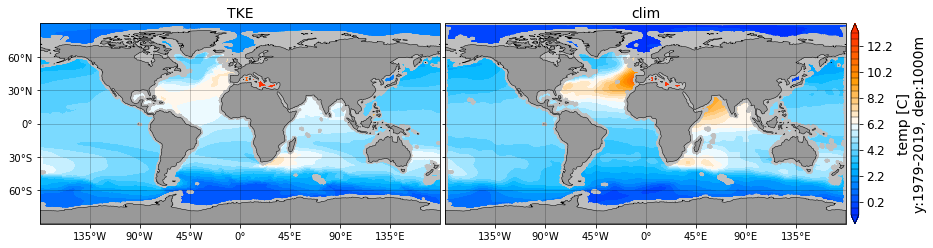

In [6]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = data_list[0][sname].attrs['str_lsave']
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
ncolumn= np.min([ncolumn,len(data_list)])    
nrow   = np.ceil(len(data_list)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname
pos_gap = [0.005, 0.04]
if proj in ['nps, sps']:pos_gap = [0.005, 0.035] 
# cinfo = dict({'cstr':'wbgyr', 'crange':[0, 5, 2.5]})
fig, ax, cbar = tpv.plot_hslice(mesh, data_list, cinfo=cinfo, box=box, n_rc=[nrow, ncolumn], 
                            figsize=[ncolumn*7, nrow*3.5], proj = proj, 
                            do_lsmask='fesom', do_rescale=do_rescale, title='descript', 
                            pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_save=spath, save_dpi=which_dpi)